# The Dining Problem

Math 100, Spring 2021

_Will Kaufman, Ivy Yan_

June 4, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 150  # 72

# Problem statement

For this problem we are assuming normal, non-COVID times. Each night during an academic year a student decides where to eat dinner. She has a choice of 3 dining venues (Foco, Collis, and Hop) and is indifferent between all of them. However, she is busy and wants to minimize the time she waits for food. If the wait time $T_W^{(i)}$ at venue $i$ follows a Poisson distribution with unknown parameter $\lambda_i$
$$
T_W^{(i)} \sim \text{Pois}(\lambda_i)
$$
what strategy would minimize the student's wait time for meals over the course of the entire academic year?

This formulation of the dining problem is exactly a multi-armed bandit problem.

# Multi-armed bandits

![From @slot_machine.](graphics/slot-machine.jpg){width=50%}



Multi-armed bandits were originally introduced by [@thompson1933likelihood, @thompson1934, @robbins1952some] as a "sequential design of experiments." Each "experiment" involves a decision to sample from one of many unknown probability distributions, and the goal is to maximize the sum of samples drawn from the distributions. For finitely many decisions, there are limited resources (the decisions to sample from one distribution) that must be allocated to maximize the expected sum. As a consequence, there must be a balance of _exploration_ of the multiple distributions and _exploitation_ of information gathered so far.

Multi-armed bandits arise in a variety of contexts. The name itself is an extension of a one-armed bandit (i.e. a slot machine) where one can choose between multiple slot machines which may have different payoff schemes. The initial research into multi-armed bandits was motivated by drug efficacy trials [@thompson1933likelihood, @thompson1934] and industrial quality control [@robbins1952some]. Multi-armed bandits also manifest in allocating research funding for clinical trials, deciding which department to take courses in at college, andthe dining problem we introduce above.

The general multi-armed bandit problem features a set of $K$ real-valued probability distributions $B = \{B_1, B_2, \dots, B_K \}$ with means $\mu_1, \mu_2, \dots, \mu_K$. A particular distribution $B_k$ is chosen to be sampled at timestep $t$, which is referred to as the action $a_t = k$. The corresponding sample is the _reward_ $r_t$. The goal of the multi-armed bandit problem is to maximize the total rewards over $T$ timesteps.
The _regret_ after $t$ decisions is defined as

$$\rho=t\mu_* - \sum_{i=1}^t r_i$$

where $\mu_* = \max_k \{ \mu_k \}$. Informally, regret measures how much worse the decisions were compared to the expected optimal policy (i.e. sampling the distribution with highest mean $t$ times).

It is often helpful to define a function that maps actions (i.e. decisions to sample from a particular distribution) to the expected reward. This function is referred to as the action-value function or the Q function.
If we knew the means of each distribution, the Q function would simply be
$$
q_*(a = k) = \mathbb{E}[r | a = k] = \mu_k
$$
Because the expected values are not known, we instead estimate $Q_t(a)$ and iteratively update the estimates as more samples are realized. For a given $Q_t$, an action can be selected to _exploit_ the information so far by
$$
a_t = {\arg \max}_k Q_t(k)
$$
This does not take into account any uncertainty in the estimates given by $Q_t$.

For the dining problem, the student wishes to minimize her total wait time, so the rewards can be defined as

$$r_t = -T_W^{(i)}$$

By maximizing rewards, she minimizes wait time. This in turn corresponds to maximizing the Q function.

# Problem setup



TODO describe how the simulations were set up
TODO change wording to include regret
TODO make pretty and such

In [3]:
lambdas = np.array([4, 5, 6])
wait_times = np.random.poisson(lam=lambdas, size=(1000, 70*3, lambdas.size))

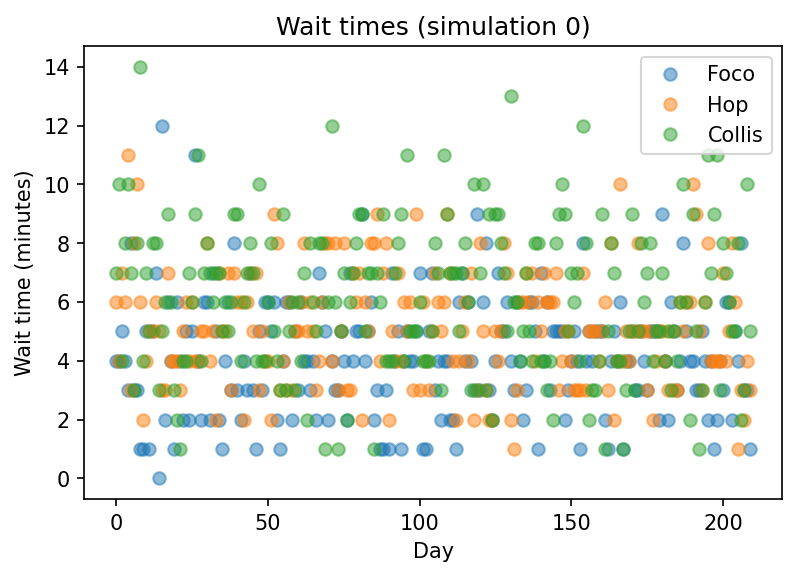

In [4]:
plt.plot(wait_times[0, :, 0], marker='o', linestyle='none', alpha=.5, label='Foco')
plt.plot(wait_times[0, :, 1], marker='o', linestyle='none', alpha=.5, label='Hop')
plt.plot(wait_times[0, :, 2], marker='o', linestyle='none', alpha=.5, label='Collis')
plt.legend()
plt.title('Wait times (simulation 0)')
plt.xlabel('Day')
plt.ylabel('Wait time (minutes)')

plt.show()

# Same old same old...

What if the student always goes to the venue with the lowest average wait time so far?

Also called "greedy policy" [@pearl1984heuristics]

1. Picks action $a$ with maximized $Q_t(a)$
    - Which venue the student has experienced the shortest average wait time so far
    $$
    A \leftarrow {\arg \max}_a Q_t(a)
    $$
2. Increment visit count for chosen $a$ (venue), update estimated $Q_t(a)$
    $$
    N_{t+1}(A) \leftarrow N_t(A) + 1, Q_{t+1}(A) \leftarrow Q_t(A)  + \frac{1}{N_{t+1}(A)} [R_{t+1} - Q_t(A)]
    $$


In [5]:
chosen_wait_times = np.zeros((wait_times.shape[0], 70*3))
extra_time = np.zeros((wait_times.shape[0], 70*3))

In [6]:
for _ in range(wait_times.shape[0]):
    N = np.zeros((3,))
    Q_estimate = np.zeros((3,))
    actions = np.zeros((wait_times.shape[1],), dtype=int)
    for i in range(wait_times.shape[1]):
        a = Q_estimate.argmin()
        actions[i] = a
        w = wait_times[_, i, a]
        chosen_wait_times[_, i] = w
        N[a] += 1
        Q_estimate[a] = Q_estimate[a] + 1/N[a]*(w - Q_estimate[a])
    extra_time[_, :] = chosen_wait_times[_, :] - wait_times[_, :, lambdas.argmin()]

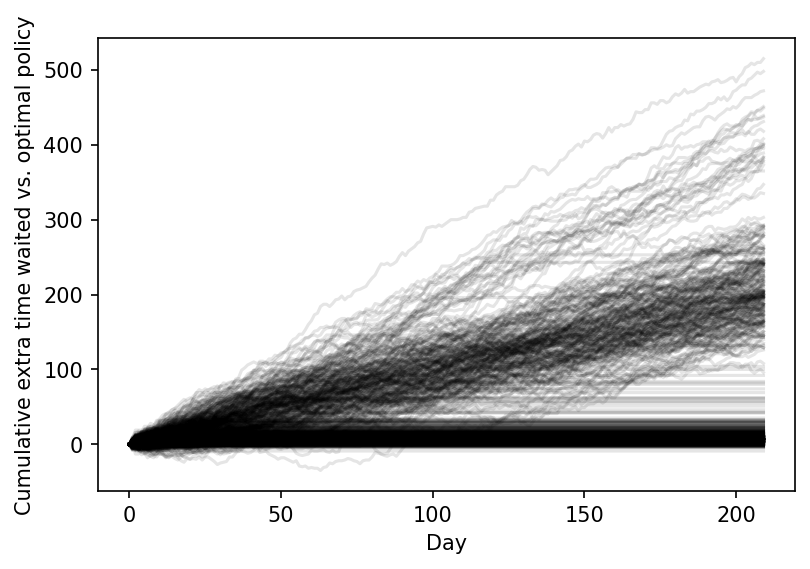

In [7]:
plt.plot(extra_time.cumsum(axis=1).T, color='k', alpha=.1)
plt.xlabel('Day')
plt.ylabel('Cumulative extra time waited vs. optimal policy')
plt.show()

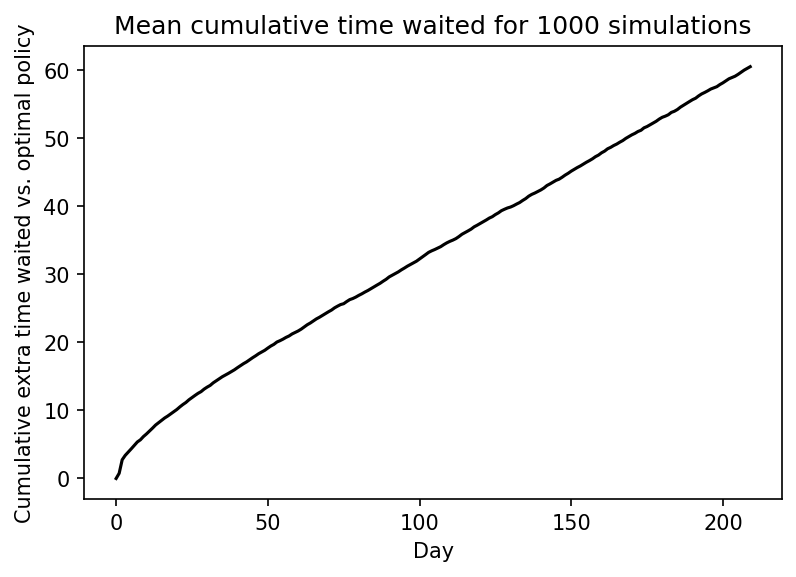

In [8]:
plt.plot(extra_time.cumsum(axis=1).mean(axis=0), color='k')
plt.xlabel('Day')
plt.ylabel('Cumulative extra time waited vs. optimal policy')
plt.title(f'Mean cumulative time waited for {wait_times.shape[0]} simulations')
plt.show()

In [9]:
extra_time.sum(axis=1).mean()

60.539

# O-week exploration, then same old...

What if our student tries out different venues for the first two weeks, then settles on whichever had the lowest empirical wait time?

More commonly called "$\epsilon$-first strategy"

1. For first $\epsilon n$ decisions, pick random actions
    - Increment visit count for chosen $a$ (venue), update estimated $Q_t(a)$
    $$
    N_{t+1}(A) \leftarrow N_t(A) + 1, Q_{t+1}(A) \leftarrow Q_t(A)  + \frac{1}{N_{t+1}(A)} [R_{t+1} - Q_t(A)]
    $$
2. For last $(1-\epsilon)n$ decisions, pick action $a$ with maximized $Q_t(a)$
    $$
    A \leftarrow {\arg \max}_a Q_t(a)
    $$


In [10]:
chosen_wait_times = np.zeros((wait_times.shape[0], 70*3))
extra_time = np.zeros((wait_times.shape[0], 70*3))

In [11]:
for _ in range(wait_times.shape[0]):
    random_picks = np.random.randint(3, size=(14,))
    random_picks = np.eye(3, dtype=int)[random_picks]
    chosen_wait_times_0 = wait_times[_, :14, :] * random_picks
    Q_estimate = chosen_wait_times_0.sum(axis=0) / random_picks.sum(axis=0)
    remaining_wait_times = wait_times[_, 14:, Q_estimate.argmin()]
    chosen_wait_times[_, :] = np.concatenate(
        [chosen_wait_times_0.sum(axis=1),
         remaining_wait_times],
        axis=0
    )
    extra_time[_, :] = chosen_wait_times[_, :] - wait_times[_, :, lambdas.argmin()]

<ipython-input-11-0ee9f1893331>:5: RuntimeWarning: invalid value encountered in true_divide
  Q_estimate = chosen_wait_times_0.sum(axis=0) / random_picks.sum(axis=0)


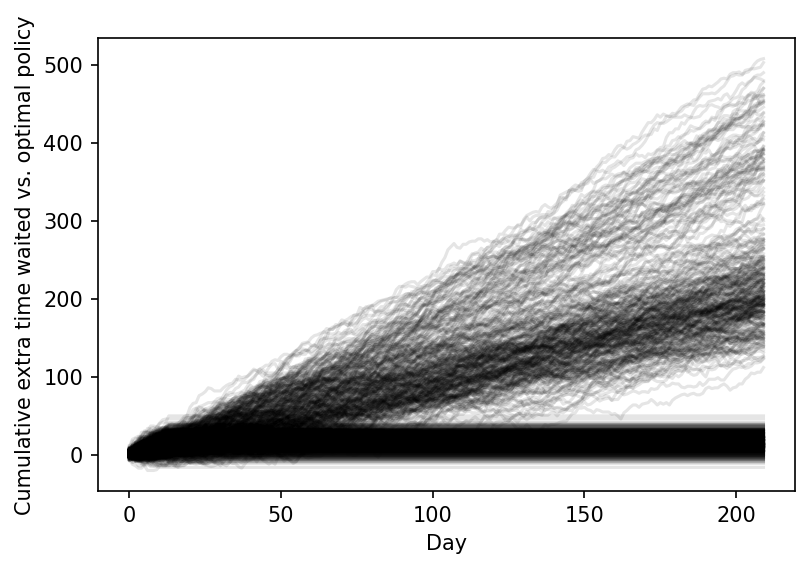

In [12]:
plt.plot(extra_time.cumsum(axis=1).T, color='k', alpha=.1)
plt.xlabel('Day')
plt.ylabel('Cumulative extra time waited vs. optimal policy')
plt.show()

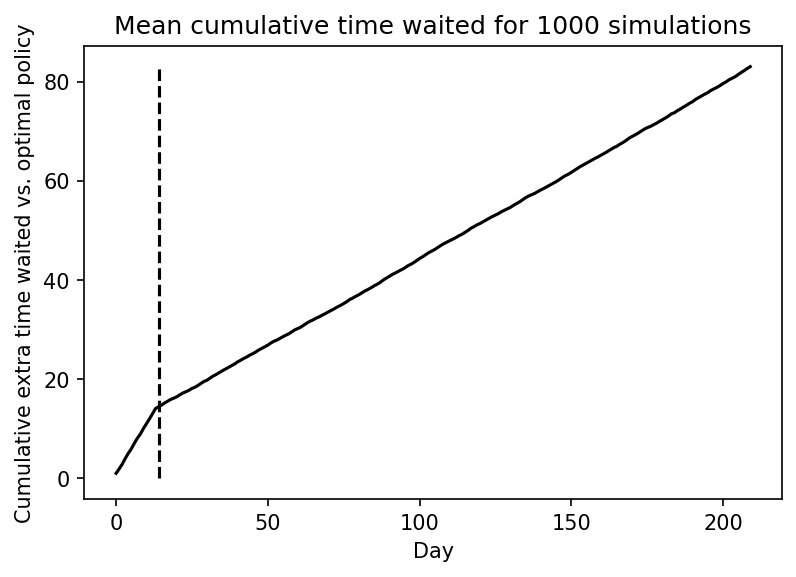

In [13]:
y = extra_time.cumsum(axis=1).mean(axis=0)
plt.plot(y, color='k')
plt.vlines(x=14, ymin=0, ymax=y.max(), color='k', linestyle='dashed')
plt.xlabel('Day')
plt.ylabel('Cumulative extra time waited vs. optimal policy')
plt.title(f'Mean cumulative time waited for {wait_times.shape[0]} simulations')
plt.show()

In [14]:
extra_time.sum(axis=1).mean()

83.06

# Occasionally spontaneous

What if the student acts greedy _most_ of the time, but occasionally goes crazy and does something different?

Called "$\epsilon$-greedy policy"

1. With probability $1-\epsilon$, picks action $a$ with maximized $Q(a)$
    $$
    A \leftarrow {\arg \max}_a Q(a)
    $$
    
    With probability $\epsilon$, picks random action $a$
    
2. Increment visit count for chosen $a$ (venue), update estimated $Q(a)$
    $$
    N(A) \leftarrow N(A) + 1, Q(A) \leftarrow Q(A)  + \frac{1}{N(A)} [R - Q(A)]
    $$

Spontaneity is a good thing!!!

In [15]:
epsilon_array = np.array([.01, .05, .2, .5])

In [16]:
chosen_wait_times = np.zeros((epsilon_array.shape[0], wait_times.shape[0], 70*3))
extra_time = np.zeros((epsilon_array.shape[0], wait_times.shape[0], 70*3))

In [17]:
for e_ind, epsilon in enumerate(epsilon_array):
    for _ in range(wait_times.shape[0]):
        N = np.zeros((3,))
        Q_estimate = np.zeros((3,))
        actions = np.zeros((wait_times.shape[1],), dtype=int)
        for i in range(wait_times.shape[1]):
            if np.random.rand() > epsilon:
                a = Q_estimate.argmin()
            else:
                a = np.random.choice(Q_estimate.size)
            actions[i] = a
            w = wait_times[_, i, a]
            chosen_wait_times[e_ind, _, i] = w
            N[a] += 1
            Q_estimate[a] = Q_estimate[a] + 1/N[a]*(w - Q_estimate[a])
        extra_time[e_ind, _, :] = chosen_wait_times[e_ind, _, :] - wait_times[_, :, lambdas.argmin()]

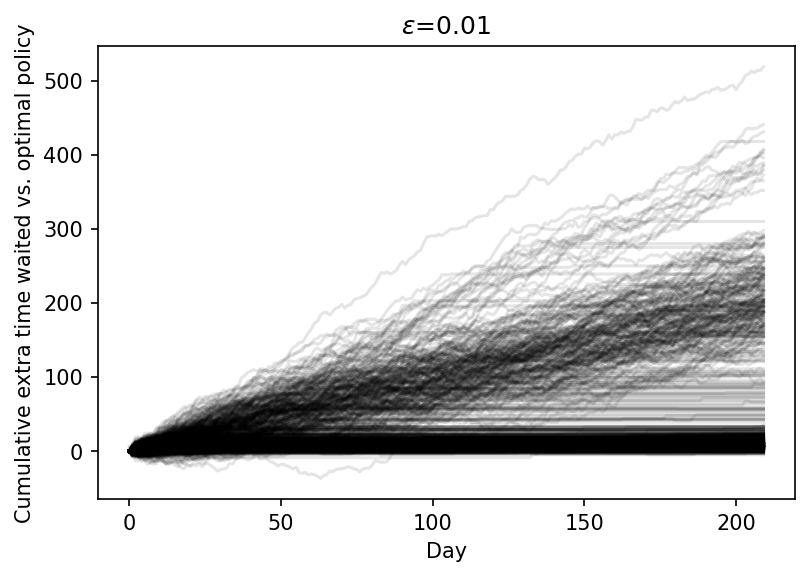

In [18]:
plt.plot(extra_time[0, ...].cumsum(axis=1).T, color='k', alpha=.1)
plt.xlabel('Day')
plt.ylabel('Cumulative extra time waited vs. optimal policy')
plt.title(fr'$\epsilon$={epsilon_array[0]}')
plt.show()

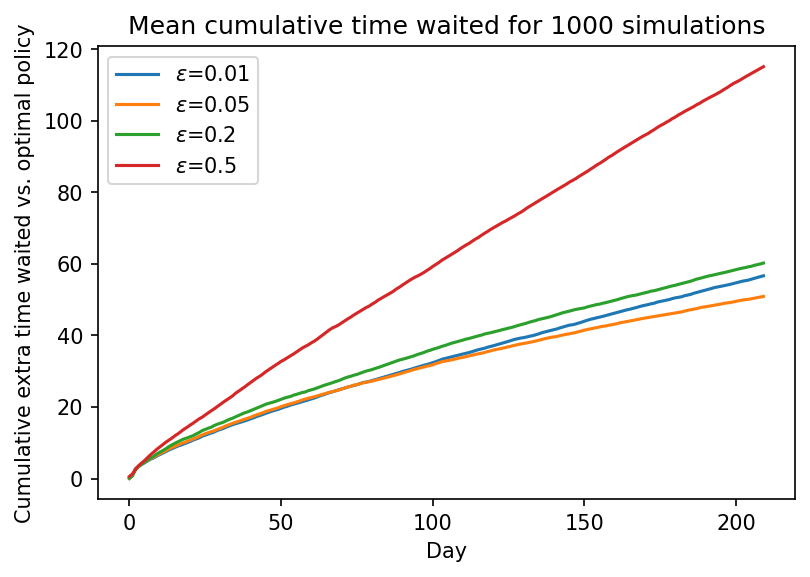

In [19]:
for e_ind, epsilon in enumerate(epsilon_array):
    plt.plot(extra_time[e_ind, ...].cumsum(axis=1).mean(axis=0), label=fr'$\epsilon$={epsilon}')
plt.xlabel('Day')
plt.ylabel('Cumulative extra time waited vs. optimal policy')
plt.title(f'Mean cumulative time waited for {wait_times.shape[0]} simulations')
plt.legend()
plt.show()

In [20]:
extra_time.sum(axis=2).mean(axis=1)

array([ 56.649,  50.881,  60.212, 115.085])

# The time-crunched math major

The student took decision theory, so she understands she needs to balance maximizing expected value while reducing uncertainty in those estimates. One way she can do this is by maximizing the "upper confidence bound (UCB) score" [@auer2002finite]

$$
A_t \dot{=} {\arg \max}_a \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right]
$$

- $Q_t(a)$ is estimate for expected value
- $\sqrt{\frac{\ln t}{N_t(a)}}$ quantifies uncertainty of estimate for action $a$
    - Choosing action $a$ will increase $N(a)$, decrease uncertainty
    - $\ln t$ de-prioritizes exploration over time
- $c$ controls the amount of exploration

In [21]:
c_array = np.array([.5, 1, 2, 4, 8])

In [22]:
chosen_wait_times = np.zeros((c_array.shape[0], wait_times.shape[0], 70*3))
extra_time = np.zeros((c_array.shape[0], wait_times.shape[0], 70*3))

In [23]:
for c_ind, c in enumerate(c_array):
    for _ in range(wait_times.shape[0]):
        N = np.zeros((3,))
        Q_estimate = np.zeros((3,))
        actions = np.zeros((wait_times.shape[1],), dtype=int)
        for i in range(wait_times.shape[1]):
            ucb_score = -Q_estimate + c * np.sqrt(np.log(i + 1) / (N + 1e-100))
            a = ucb_score.argmax()
            actions[i] = a
            w = wait_times[_, i, a]
            chosen_wait_times[c_ind, _, i] = w
            N[a] += 1
            Q_estimate[a] = Q_estimate[a] + 1/N[a]*(w - Q_estimate[a])
        extra_time[c_ind, _, :] = chosen_wait_times[c_ind, _, :] - wait_times[_, :, lambdas.argmin()]

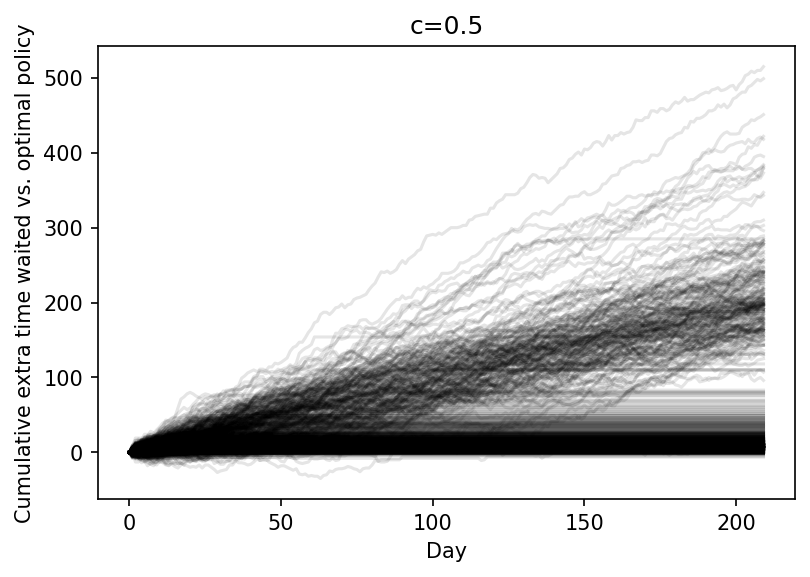

In [24]:
plt.plot(extra_time[0, ...].cumsum(axis=1).T, color='k', alpha=.1)
plt.xlabel('Day')
plt.ylabel('Cumulative extra time waited vs. optimal policy')
plt.title(f'c={c_array[0]}')
plt.show()

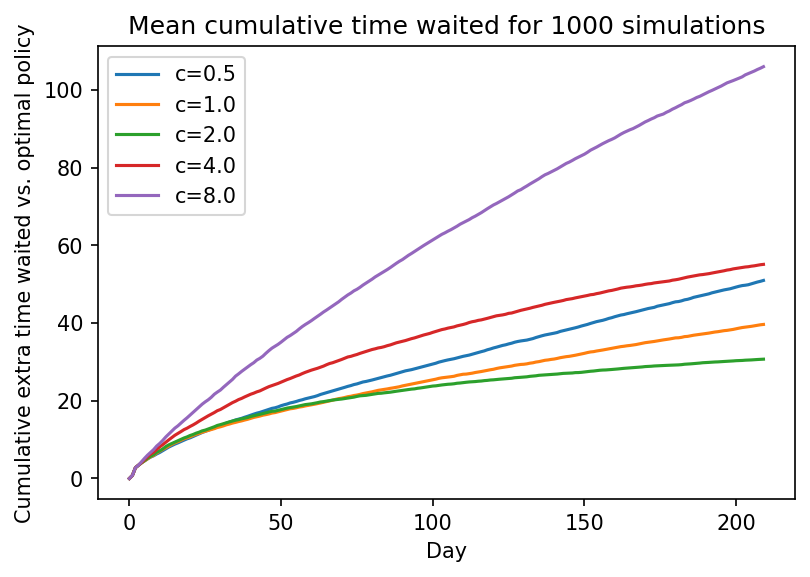

In [25]:
for c_ind, c in enumerate(c_array):
    plt.plot(extra_time[c_ind, ...].cumsum(axis=1).mean(axis=0), label=f'c={c}')
plt.xlabel('Day')
plt.ylabel('Cumulative extra time waited vs. optimal policy')
plt.title(f'Mean cumulative time waited for {wait_times.shape[0]} simulations')
plt.legend()
plt.show()

In [26]:
extra_time.sum(axis=2).mean(axis=1)

array([ 50.968,  39.644,  30.704,  55.101, 105.976])

# Comparison of different policies

- UCB does best by balancing exploration and exploitation
    - More effort than most people would put in to deciding where to eat
- Occasional spontaneity ($\epsilon$-greedy) does pretty well, and it's simple!
    - Go where you normally go most of the time, but be open to trying something new once in a while

# Other considerations

- Non-stationary distributions: wait times might be different each term
- Contextual bandits: weekdays vs. weekends
- Utility function: food preferences, social time, distance, price, ...
    - Opportunity cost of all the time spent optimizing dining venue!